<a href="https://colab.research.google.com/github/ImanNoferesti/TensorFlow_DeepDive/blob/main/Malaria_Diagnosis_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam


### Data Prepration

The function `tfds.load()` is used to load datasets from TensorFlow Datasets (TFDS), a collection of ready-to-use datasets for machine learning.

Parameters:

* `name`: The name of the dataset (e.g., 'mnist', 'cifar10').

* `split`: Specifies the data subset to load (e.g., 'train', 'test').

* `as_supervised`: If set to `True`, it returns the dataset in the form `(input, label)` pairs.

* `batch_size`: Allows you to load the dataset in batches.

In [78]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

In [79]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

In [80]:
dataset

for data in dataset[0].take(3):
  print(data)

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(133, 127, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [81]:
# Create a dataset containing a range of numbers from 0 to 9
dataset = tf.data.Dataset.range(10)
# Skip the first 7 elements, resulting in a dataset starting from the 7th element (index 7)
taken_after_skipping_dataset = dataset.skip(7)
taken_dataset = dataset.take(3)
# Convert the dataset to a list of numpy arrays and print it
print(list(taken_after_skipping_dataset.as_numpy_iterator()))
print(list(taken_dataset.as_numpy_iterator()))

[7, 8, 9]
[0, 1, 2]


In [82]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [83]:
# Example for understanding how the split function should perform

dataset = tf.data.Dataset.range(10)
dataset_size = len(dataset)

train_dataset = dataset.take(int(TRAIN_RATIO * dataset_size))
print(list(train_dataset.as_numpy_iterator()))

val_dataset = dataset.skip(int(TRAIN_RATIO * dataset_size)).take(int(VAL_RATIO * dataset_size))
print(list(val_dataset.as_numpy_iterator()))

test_dataset = dataset.skip(int((TRAIN_RATIO + VAL_RATIO) * dataset_size))
print(list(test_dataset.as_numpy_iterator()))

[0, 1, 2, 3, 4, 5, 6, 7]
[8]
[9]


In [84]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):

  dataset_size = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO * dataset_size))
  val_dataset = dataset.skip(int(TRAIN_RATIO * dataset_size)).take(int(VAL_RATIO * dataset_size))
  test_dataset = dataset.skip(int((TRAIN_RATIO + VAL_RATIO) * dataset_size))

  return train_dataset, val_dataset, test_dataset


In [85]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

train_dataset, val_dataset, test_dataset = split(dataset[0],TRAIN_RATIO, VAL_RATIO, TEST_RATIO)


### Data Visualization

The `enumerate()` function in Python is a built-in function that adds a counter to an iterable and returns it as an `enumerate` object. This allows you to loop over an iterable (like a list, tuple, or dataset) and keep track of the index at the same time.

How `enumerate()` Works:

* `enumerate(iterable, start=0)` takes two parameters:
  * `iterable`: The sequence (like a list or dataset) that you want to iterate over.
  * `start`: The starting value for the counter (default is `0`).


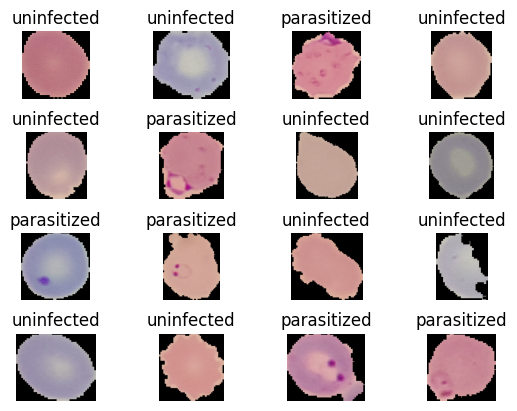

In [86]:
# Iterate over the first 16 images and labels in the training dataset
for i, (image, label) in enumerate(train_dataset.take(16)):
  # Create a subplot with 4 rows and 4 columns
  # The current subplot is determined by i+1 (1-based index)
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

### Data Preprocessing

The `tf.image.resize()` function in TensorFlow is used to resize images to a specified size. This function is particularly useful in image preprocessing for machine learning models, where input images need to be of uniform dimensions.

Parameters:

* `images`: The input image or batch of images to be resized. It should be a 3D (single image) or 4D (batch of images) tensor.

* `size`: A 1-D tensor or list specifying the new size `[new_height, new_width]`.

* `method`: The interpolation method used for resizing. Options include `'bilinear'`, `'nearest'`, `'bicubic'`, and `'lanczos3'`, among others. The default is `'bilinear'`.

* `preserve_aspect_ratio`: If `True`, the function preserves the original aspect ratio of the image while resizing.

* `antialias`: If `True`, an anti-aliasing filter is applied when resizing. This can help reduce visual artifacts.

* `name`: An optional name for the operation.

In [87]:
# Normalization =>  x = (x - xmin) / (xmax - xmin) In our case xmin = 0 pixels and xmax = 255

IM_SIZE = 224
x_max = 255.0

def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/x_max, label

The `map()` function in TensorFlow's `tf.data.Dataset` API is used to apply a specified function to each element of the dataset. This is helpful for preprocessing data, such as resizing images, normalizing data, or augmenting images, before they are used for training or evaluation in a machine learning model.

Use Cases for `map()`:

* **Preprocessing images**: Resize, normalize, or augment images.
* **Data transformation**: Apply data type conversions or feature scaling.
* **Feature extraction**: Extract or compute additional features from the data.

In [88]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [89]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [90]:
# Shuffle the dataset, batch it into groups of 32, and prefetch data for optimal pipeline performance
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [91]:
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

### Model Creation

CNN Explainer: https://poloclub.github.io/cnn-explainer/

CNN For Visual Recognition: https://cs231n.github.io/

CNN Arithmetic: https://github.com/vdumoulin/conv_arithmetic

To calculate the output dimensions of a feature map after applying a convolutional operation in a convolutional neural network (CNN), considering filter size, stride, and padding, is:

$$
W_{out} = \left\lfloor \frac{W_{in} - F + 2P}{S} \right\rfloor + 1
$$

$$
H_{out} = \left\lfloor \frac{H_{in} - F + 2P}{S} \right\rfloor + 1
$$

Definitions:

* `Wout` and `Hout`: The width and height of the output feature map.

* `Win` and `Hin`: The width and height of the input feature map.

* `F`: The filter size (kernel size).

* `P`: The amount of zero-padding applied to the input.

* `S`: The stride, which is the step size that the filter moves across the input.

* `⌊ ⌋`: The floor function, which rounds down to the nearest integer.

Image Kernels: https://setosa.io/ev/image-kernels/


An **image kernel**, also known as a filter or convolution kernel, is a small matrix used in image processing and computer vision to perform various operations on images, such as blurring, sharpening, edge detection, and more. The kernel is applied to an image through a process called convolution, where the kernel matrix slides over the image, performing element-wise multiplications and summing the results to produce a new pixel value.

Key Concepts:

1. **Kernel Size**: The kernel is usually a square matrix (e.g., 3x3, 5x5) that defines the area of pixels considered in the operation. Common sizes include 3x3 and 5x5.

2. **Convolution Process:**

  * The kernel is placed over the image such that its center aligns with a specific pixel.

  * Each value in the kernel is multiplied by the corresponding pixel value beneath it.

  * The products are summed up to produce a single output pixel.

  * The kernel then moves to the next pixel, and the process repeats.

3. **Types of Kernels:**

  * **Blurring Kernel**: Averages the surrounding pixel values, creating a smooth image. Example:
  $$
\text{Gaussian Kernel} = \begin{bmatrix}
\frac{1}{16} & \frac{2}{16} & \frac{1}{16} \\
\frac{2}{16} & \frac{4}{16} & \frac{2}{16} \\
\frac{1}{16} & \frac{2}{16} & \frac{1}{16}
\end{bmatrix}
$$

  * **Sharpening Kernel**: Enhances edges by amplifying differences between neighboring pixels. Example:

  $$
\text{Laplacian Kernel} = \begin{bmatrix}
0 & -1 & 0 \\
-1 & 4 & -1 \\
0 & -1 & 0
\end{bmatrix}
$$

  * **Edge Detection Kernel**: Identifies edges in an image by highlighting areas of high contrast. Example:

  $$
\text{Sobel Kernel} = \begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}
$$

4. **Padding**: To ensure that the kernel can process the edges of an image without losing information, padding (usually zero-padding) may be added around the image.

5. **Stride**: The stride defines how many pixels the kernel moves at a time. A stride of 1 means it moves one pixel at a time, while a stride of 2 skips every other pixel.



**Max pooling** is a downsampling technique commonly used in convolutional neural networks (CNNs) to reduce the spatial dimensions (width and height) of feature maps while retaining the most important information. It operates by partitioning the input feature map into a set of non-overlapping rectangles and taking the maximum value from each rectangle. This process helps to summarize the features in the region and reduces the computational load for subsequent layers in the network.

Key Concepts:

1. **Operation**:
  * The max pooling operation is typically defined by a **kernel size** (also called the pooling window) and a **stride** (the step size for moving the window).

    *  For example, with a 2x2 max pooling operation and a stride of 2, the pooling layer will cover a 2x2 area of the input feature map, take the maximum value from that area, and move to the next non-overlapping 2x2 region.

2. **Formulation**:
  * Given an input feature map \(X\), the output feature map \(Y\) after applying max pooling can be defined as:

   $$
   Y_{i,j} = \max(X_{a,b}) \quad \text{for } a, b \text{ in the pooling window}
   $$

   where \(i\) and \(j\) are the indices of the output feature map, and \(a\) and \(b\) are the indices of the corresponding region in the input feature map.

3. **Benefits**:
  * **Dimensionality Reduction**: By reducing the size of the feature maps, max pooling decreases the number of parameters and computations in the network, which helps to prevent overfitting.

  * **Translation Invariance**: Max pooling helps the network to become less sensitive to small translations in the input, as the most prominent features (the maximum values) are preserved.

4. **Pooling Size and Stride**:
  * Common choices for the pooling size are 2x2 or 3x3, with a stride often equal to the pooling size to ensure non-overlapping regions.

  * If a stride is smaller than the pooling size, it results in overlapping pooling regions.


Example:

Given the following 4x4 input feature map:

$$
   X = \begin{bmatrix}
   1 & 3 & 2 & 4 \\
   5 & 6 & 2 & 1 \\
   3 & 2 & 1 & 0 \\
   4 & 5 & 6 & 7
   \end{bmatrix}
   $$

   If we apply 2x2 max pooling with a stride of 2, the output will be:

   $$
   Y = \begin{bmatrix}
   6 & 4 \\
   5 & 7
   \end{bmatrix}
   $$
   
   Here, the maximum values from each 2x2 region are taken.

-

`tf.keras.layers.Conv2D()` is a 2D convolutional layer in TensorFlow/Keras, primarily used in building convolutional neural networks (CNNs) for processing image data. It performs the convolution operation, which involves sliding a filter (or kernel) over the input image and computing the dot product between the filter and the input at each position. This process helps extract spatial features like edges, textures, and patterns.

Key Parameters:

* `filters`: The number of output filters (i.e., the number of feature maps produced).

* `kernel_size`: The dimensions of the filter (e.g., (3, 3)).

* `strides`: The step size for moving the filter across the input.

* `padding`: Specifies how the borders of the input are handled, either `'valid'` (no padding) or `'same'` (padding to keep the output size consistent).

* `activation`: The activation function applied to the output (e.g., 'relu').



`tf.keras.layers.MaxPool2D()` is a max pooling layer in TensorFlow/Keras, used in convolutional neural networks (CNNs) to reduce the spatial dimensions of the input, thereby decreasing the number of parameters and computational load while retaining the most important features.

Max pooling operates by dividing the input into smaller rectangular regions (defined by `pool_size`) and selecting the maximum value from each region. This process helps make the network more robust to small translations and variations in the input image.

Key Parameters:

* `pool_size`: The size of the pooling window, typically (2, 2) to reduce the input dimensions by half.

* `strides`: The step size for moving the pooling window across the input. Defaults to the `pool_size` if not specified.

* `padding`: Can be `'valid'` (no padding) or `'same'` (padding added to maintain the same output dimensions).

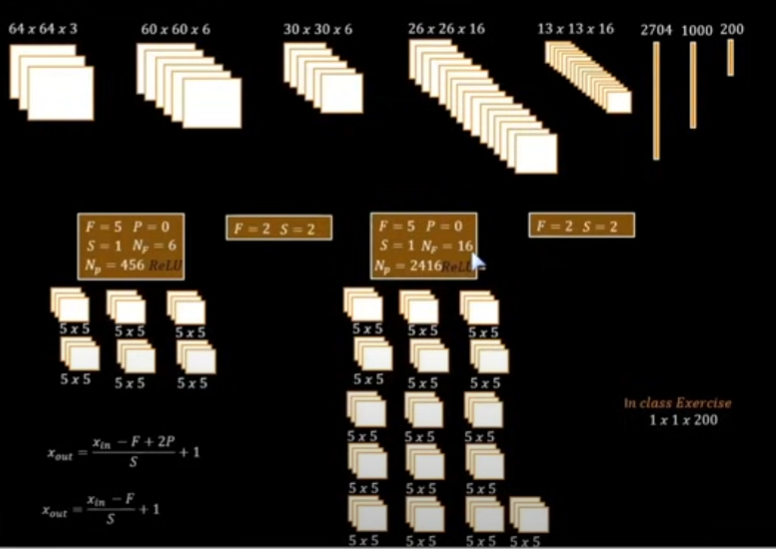

In [92]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='relu'),
    BatchNormalization(),

    Dense(10, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='sigmoid')
])

lenet_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

### Error Sanctioning

`tf.keras.losses.BinaryCrossentropy()` is a loss function in TensorFlow/Keras used for binary classification problems, where the output can be one of two classes (e.g., 0 or 1). It measures the difference between the true labels and the predicted probabilities, effectively quantifying how well the model's predictions match the actual outcomes.

How It Works:

Binary cross-entropy calculates the loss for each example by comparing the predicted probability (`p`) with the true label (`y`). The formula for binary cross-entropy is:

$$
\text{Loss} = - \frac{1}{N} \sum_{i=1}^{N} \left( y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right)
$$

where:

* `N` is the number of samples.

* $y_i$ is the true label for the ith sample (0 or 1).

* $p_i$  is the predicted probability for the ith sample.

Key Parameters:

* **from_logits**: Boolean indicating whether the predictions are given as logits (unnormalized scores) or probabilities (values between 0 and 1). If `True`, the function will apply a `sigmoid` activation before computing the loss.

* **label_smoothing**: A value between 0 and 1 used to smooth the labels. This can help make the model more robust to overconfident predictions.

In [97]:
lenet_model.compile(optimizer=Adam(learning_rate=0.01),
              loss = BinaryCrossentropy(),
                    metrics = ['accuracy'])

### Training CNN

In [ ]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8082 - loss: 0.4036

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val_loss'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

### Model Evaluation and Testing

In [ ]:
test_dataset

In [ ]:
train_dataset

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
lenet_model.evaluate(test_dataset)

In [ ]:
lenet_model.predict(test_dataset.take(1))[0][0]

In [ ]:
def parasite_or_not(x):
  if x < 0.5:
    return 'P'
  else:
    return 'U'

In [ ]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plot.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title("Actual: " + str(parasite_or_not(label.numpy()[0])) + "\n" + "Predicted: " + str(parasite_or_not(lenet_model.predict(image)[0][0])))
  plt.axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)